## $\textbf{Automatic X-ray image segmentation - 02456 Deep Learning Exam project}$


## $\textbf{Preliminaries}$

In [8]:
%matplotlib inline
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import random_split, DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from torch.nn.functional import normalize
import torchvision.transforms.functional as TF
import torch.nn.init as init
from sklearn import metrics
import glob
import pandas as pd
import os
from IPython.display import clear_output
from skimage.io import imread
from skimage.transform import resize
from PIL import Image
import pickle
import math
from tqdm import tqdm

sns.set_style("whitegrid")

## $\textbf{Retrieve project}$

Mount google drive when using Google Colab:

In [9]:
# Mount drive:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Retrieve input- and label data (**Insert own project_path**):

In [10]:
# Find directories:
project_path = "drive/My Drive/Projekt/training_dataset/" #Ludvik
# project_path = "drive/My Drive/Deep_learning/Projekt/training_dataset/" #Cassandra
#project_path = "drive/Shared with me/Projekt/training_dataset/" #Ulrika
data_paths =  sorted(glob.glob(project_path + "data/*.tiff"))
label_paths = sorted(glob.glob(project_path + "labels/*.tif"))

# Load saved data images and models:
saved_data_images = project_path + "saved_data/"
saved_models = project_path + "models/"

Descriptive data of input- and label images:

In [11]:
# Open arbitrary image from input:
img = Image.open(data_paths[0])

# Simple data:
input_size = float(len(data_paths))
print(f"Number of inputs: {len(data_paths)}")
print(f"Number of labels: {len(label_paths)}")

# Display basic image information
print("Image Format:", img.format)
print("Image Mode:", img.mode) # (I;16 = image is grayscale; 16 bit integers)
print("Image Size:", img.size) # (width, height)
print("Image Info:", img.info)
print()

# Same for label data:
label_img = Image.open(label_paths[0])
print("Image Format:", label_img.format)
print("Image Mode:", label_img.mode) # (L = grayscale)
print("Image Size:", label_img.size) # (width, height)
print("Image Info:", label_img.info)

Number of inputs: 500
Number of labels: 500
Image Format: TIFF
Image Mode: I;16
Image Size: (501, 501)
Image Info: {'compression': 'packbits', 'dpi': (72.0, 72.0)}

Image Format: TIFF
Image Mode: L
Image Size: (501, 501)
Image Info: {'compression': 'packbits', 'dpi': (72.0, 72.0)}


## $\textbf{Load data}$

Data manipulation functions:

In [56]:
# Create masks from label images:
def create_masks(images):
  black_mask = images == 0
  gray_mask = images == 1
  white_mask = images == 2

  return torch.cat([black_mask, gray_mask, white_mask], dim=1)

# Normalize tensor according to image size:
def normalize_tensor(data):
    return (data - torch.min(data)) / (torch.max(data) - torch.min(data))

# Crop image to create 9 separate images:
def multiply_img(path, is_label_data):
  img = Image.open(path) # Load image

  images = [img.crop((0, 0, 128, 128)), # [(left, top, right, bottom)]
            img.crop((128, 0, 128*2, 128)),
            img.crop((128*2, 0, 128*3, 128)),

            img.crop((0, 128, 128, 128*2)),
            img.crop((128, 128, 128*2, 128*2)),
            img.crop((128*2, 128, 128*3, 128*2)),

            img.crop((0, 128*2, 128, 128*3)),
            img.crop((128, 128*2, 128*2, 128*3)),
            img.crop((128*2, 128*2, 128*3, 128*3))] # Cropping image


  # Turn to tensor and append to lst:
  lst = []
  for cropped_img in images:
    if is_label_data:
      lst.append(apply_label_transform(cropped_img))

    else:
      img_array = np.array(cropped_img).astype(np.float32) # img as np array
      lst.append(torch.from_numpy(img_array).unsqueeze(0)) # Format to tensor

  return lst


# Apply transform to input images:
def apply_transform(path):
  img = Image.open(path) # Load image

  img = img.crop((0, 0, 128, 128)) # Cropping image

  img_array = np.array(img).astype(np.float32) # img as np array

  return torch.from_numpy(img_array).unsqueeze(0) # Format to tensor


# Apply transform to input images:
def apply_transform2(tensor, noise):

  # Add noise if set to true:
  if noise == True:
  # if noise:
    sigma = 10000
    Noise = sigma * torch.randn(1,128,128)
    data_images = normalize_tensor(tensor + Noise)
    return data_images

  elif random.random() < 0.5:
    sigma = 10000 * random.random()
    Noise = sigma * torch.randn(1,128,128)
    data_images = normalize_tensor(tensor + Noise)
    return data_images

  return normalize_tensor(tensor) # Normalize and return

# Apply transform to label images:
def apply_label_transform(img):
  img_array = np.array(img)

  img_array[img_array < 75] = 0
  img_array[np.logical_and(img_array >= 75, img_array < 150)] = 1
  img_array[img_array >= 150] = 2

  return torch.from_numpy(img_array).unsqueeze(0)

Having **not** loaded the input- and label data, run the following cells (**remember to change values in the first cell**):

In [41]:
# Choose folder to save data in:
folder_name = 'large_with_noise_50_pct'
path_to_data = saved_data_images + folder_name

# If folder doesn't exist as of yet, make directory:
if not os.path.exists(path_to_data):
  os.makedirs(path_to_data)

path_to_data += '/'

In [43]:
# Apply transformation to every image and append to list:
tensor_data = [ multiply_img(path, False) for path in data_paths ]
tensor_labels = [ multiply_img(path, True) for path in label_paths ]

# Make lists of images into tensors:
tensor_data = torch.stack([item for sublist in tensor_data for item in sublist])
tensor_labels = torch.stack([item for sublist in tensor_labels for item in sublist])

images = torch.cat([tensor_data, tensor_labels], dim=1)

# Define dataset sizes:
input_size = len(tensor_data)
T_train = int(input_size * 0.7)
T_validation = int(input_size * 0.15)
sizes = (T_train + T_validation, (input_size - (T_validation + T_train)))

# Split into train-validation- and test sets:
train_valid_images, test_images = random_split(images, sizes)

# Second transform :):
data_images = torch.stack([ apply_transform2(tensor[0].unsqueeze(0), False) for tensor in train_valid_images ])
label_images = torch.stack([ label[1].unsqueeze(0) for label in train_valid_images ])
test_data_images = torch.stack([ apply_transform2(tensor[0].unsqueeze(0), True) for tensor in test_images ])
test_label_images = torch.stack([ label[1].unsqueeze(0) for label in test_images ])

# Save images to drive for later use:
with open(path_to_data + 'data_images.pickle', 'wb') as f: # Save data_images
   pickle.dump(data_images, f)

with open(path_to_data + 'label_images.pickle', 'wb') as f: # Save label_images
   pickle.dump(label_images, f)

with open(path_to_data + 'test_data_images.pickle', 'wb') as f: # Save test_data_images
   pickle.dump(test_data_images, f)

with open(path_to_data + 'test_label_images.pickle', 'wb') as f: # Save test_label_images
   pickle.dump(test_label_images, f)

If you've already saved the data, you may load instead, saving time:

In [ ]:
# Choose folder to load data from:
folder_name = 'large_with_noise_50_pct'
path_to_data = saved_data_images + folder_name

# Raise exception if data path does not exist:
if not os.path.exists(path_to_data):
  raise Exception('Filename is incorrect - please try again.')
path_to_data += '/'

In [ ]:
# Load data_images:
with open(path_to_data + 'data_images.pickle', 'rb') as f:
  data_images = pickle.load(f)

# Load label_images:
with open(path_to_data + 'label_images.pickle', 'rb') as f:
  label_images = pickle.load(f)

# Load test_data_images:
with open(path_to_data + 'test_data_images.pickle', 'rb') as f:
  test_data_images = pickle.load(f)

# Load test_label_images:
with open(path_to_data + 'test_label_images.pickle', 'rb') as f:
  test_label_images = pickle.load(f)

Create batches from data:

In [44]:
# Recalibrate sizes:
print(len(data_images))
valid_patch = math.ceil(len(data_images) * 0.15)
sizes = (int(len(data_images) - valid_patch), int(valid_patch))
print(f"Sizes: {sizes}, addition: {sizes[0] + sizes[1]}")

# Create masks:
train_valid_masks = create_masks(label_images)
test_masks = create_masks(test_label_images)

# Compress data:
data = torch.cat([data_images, train_valid_masks], dim=1)
test_data = torch.cat([test_data_images, test_masks], dim=1)

# Split into train and validation sets:
data_train, data_valid = random_split(data, sizes)

# Define batch size:
b_size = 64 # 64 large, 25 small

# Utilize DataLoader:
train_batches = DataLoader(data_train, batch_size=b_size, shuffle=False, num_workers=0, collate_fn=None, pin_memory=False)
valid_batches = DataLoader(data_valid, batch_size=b_size, shuffle=False, num_workers=0, collate_fn=None, pin_memory=False)

3825
Sizes: (3251, 574), addition: 3825


## $\textbf{Plot data}$
Below are different functions intended for plotting:

In [45]:
def show_image(img):
    with sns.axes_style("white"):
        plt.figure(figsize=(8, 8))
        plt.imshow(img, cmap = 'gray')
        plt.axis('off')
        plt.show()

def show_tensor_image(tensor):
  with sns.axes_style("white"):
        plt.figure(figsize=(8, 8))
        plt.imshow(tensor.permute(1,2,0), cmap = 'gray')
        plt.axis('off')
        plt.show()

def hist_of_tensor(tensor):

  # Flatten the tensor
  flat_tensor = tensor.view(-1)

  # Convert tensor to numpy array
  tensor_np = flat_tensor.numpy()

  # Create histogram
  hist, bin_edges = np.histogram(tensor_np, bins=50)

  # Plot the histogram
  plt.hist(tensor_np, bins=50, alpha=0.7, color='blue', edgecolor='black')

  # Add labels and title
  plt.xlabel('Values')
  plt.ylabel('Frequency')
  plt.title('Histogram of Tensor Values')

  # Show the plot
  plt.show()

# Rescale normalized tensor and create image:
def rescaled_tensor_img(tensor):
  np_tensor = tensor.squeeze().numpy()

  if len(np_tensor.shape) > 2 and np_tensor.shape[0] > 1:
      np_tensor = np.transpose(np_tensor, (1, 2, 0))

  image_tensor = (np_tensor * 255).astype(np.uint8)
  image = Image.fromarray(image_tensor)

  if len(np_tensor.shape) > 2 and np_tensor.shape[0] > 1:
    image = Image.fromarray(image_tensor[:, :, [0, 1, 2]]).convert('L')

  return image

# Display input-, label and prediction images:
def show_comparisons(input_images, label_images, pred_images, title_fontsize=16):
    num_images = len(input_images)
    fig, axes = plt.subplots(num_images, 3, figsize=(15, 5 * num_images))

    for i in range(num_images):
        axes[i, 0].imshow(input_images[i], cmap='gray')
        axes[i, 0].set_title('Input Image', fontsize=title_fontsize)

        axes[i, 1].imshow(label_images[i], cmap='gray')
        axes[i, 1].set_title('Label Image', fontsize=title_fontsize)

        axes[i, 2].imshow(pred_images[i], cmap='gray')
        axes[i, 2].set_title('Predicted Image', fontsize=title_fontsize)

    for ax in axes.flat:
        ax.axis('off')

    plt.show()

Evaluate different aspects of the tensor values:

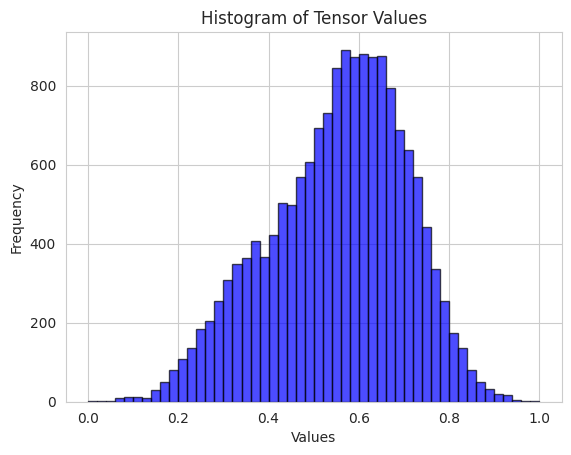

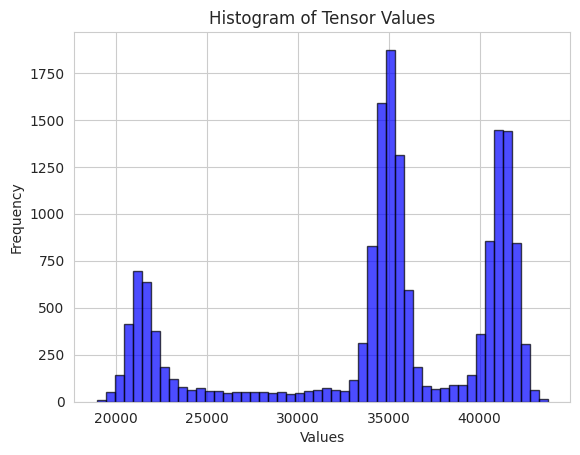

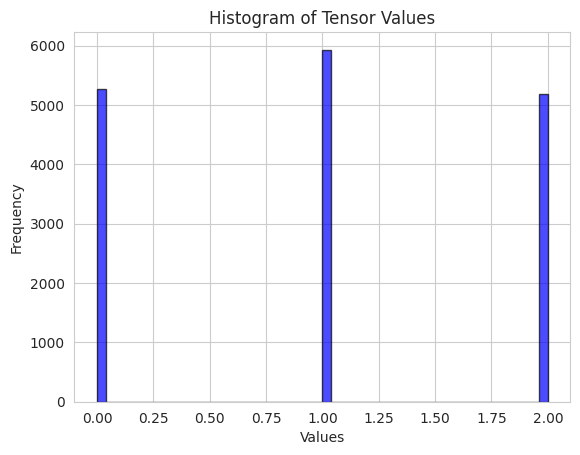

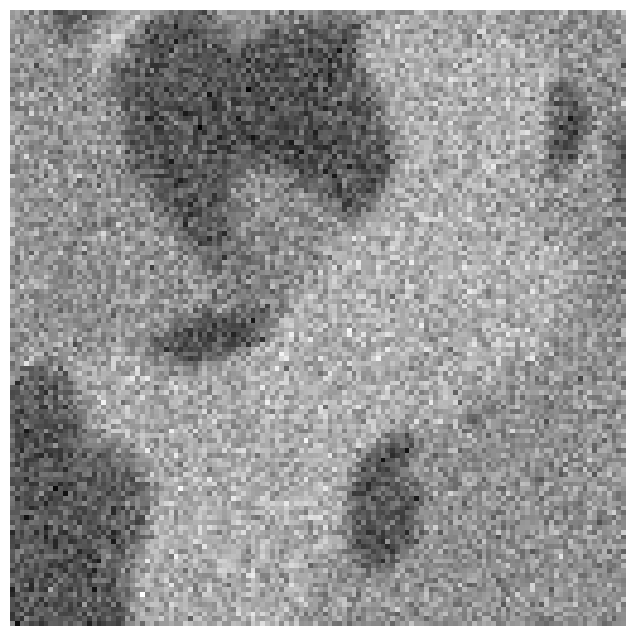

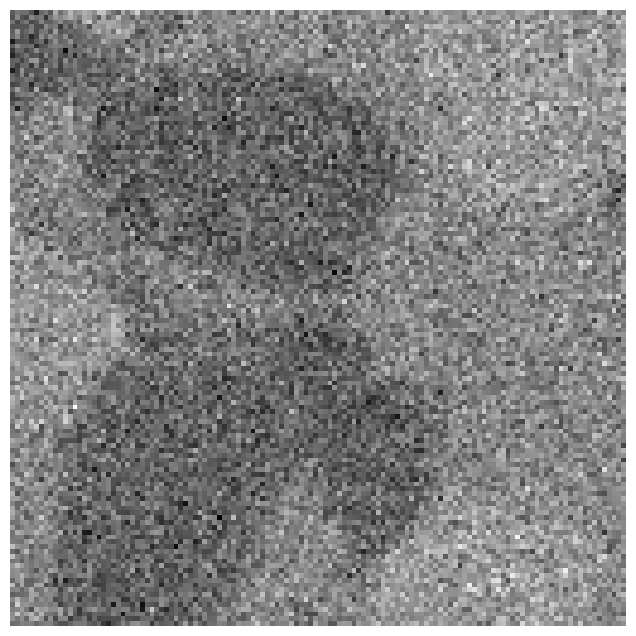

In [46]:
# Histogram of data- and label images:
hist_of_tensor(data_images[6])
hist_of_tensor(tensor_data[6])
hist_of_tensor(label_images[0])
show_tensor_image(data_images[6])
show_tensor_image(test_data_images[15])

##$\textbf{U-Net model}$

In [47]:
class EncoderBlock(nn.Module):

  def __init__(self, in_channels, out_channels):
    super(EncoderBlock, self).__init__()

    self.net = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False), # no bias as we use batchnorm (bias cancelled by b-norm)
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True), # Modify input directly without allocating additional output
        nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False), # no bias as we use batchnorm (bias cancelled by b-norm)
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True), # Modify input directly without allocating additional output
    )

  def forward(self, x):
    return self.net(x)

class UNET(nn.Module):

  # def __init__(self, in_channels=1, classes=3, features=[64,128]):
  def __init__(self, in_channels=1, classes=3, features=[64,128,256,512]):
    super(UNET, self).__init__()

    self.encoder = nn.ModuleList()

    self.decoder = nn.ModuleList()

    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    # UNET encoder:
    for feature in features:
      self.encoder.append(EncoderBlock(in_channels, feature))
      in_channels = feature

    # UNET Bottleneck:
    self.bottleneck = EncoderBlock(features[-1], features[-1]*2)

    # UNET decoder:
    for feature in reversed(features):
      self.decoder.append(
          nn.ConvTranspose2d(
              feature*2, feature, kernel_size=2, stride=2
          )
      ) # Used for upsampling

      self.decoder.append(EncoderBlock(feature*2, feature)) # Used for concat

    # Output layer:
    self.output_layer = nn.Conv2d(features[0], classes, kernel_size=1)

  def forward(self, x):
    skip_connections = [] # The gray skip in the UNET model!

    # ENCODING:
    for encode_layer in self.encoder:
      x = encode_layer(x)
      skip_connections.append(x)
      x = self.pool(x)

    # BOTTLENECK:
    x = self.bottleneck(x)
    skip_connections = skip_connections[::-1] # Reverse list

    # print(f"Shape of x -> {x.shape}")

    # DECODING - process: upsample, get skip connection, concatenate these two:
    for idx in range(0, len(self.decoder), 2):
      x = self.decoder[idx](x) # Upsample
      skip_connection = skip_connections[idx//2] # Get skip connection

      # Resize shapes such, that each layer functions as for encoder:
      if x.shape != skip_connection.shape:
        x = TF.resize(x, skip_connection.shape[2:]) # Impacts accuracy a little bit, only height x width

      cat_skip = torch.cat((skip_connection, x), dim=1) # cat skip and x. Add along channel dim (batch, channel, height, width)
      x = self.decoder[idx+1](cat_skip)

    # OUTPUT:
    return self.output_layer(x)

Test forward pass of model with simple dummy data:

In [ ]:
# Create model:
model = UNET()
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Forward pass with dummy data:
tensor = torch.randn(2, 1, 128, 128)
out = model(tensor)
print("Output shape:", out.size())
print(f"Output logits:\n{out.detach().numpy()}")
print(f"Output probabilities:\n{out.softmax(1).detach().numpy()}")

Shape of x -> torch.Size([2, 1024, 8, 8])
Output shape: torch.Size([2, 3, 128, 128])


## $\textbf{Training utilities}$

Below are functions used in relation to training of the model:

In [48]:
def train_fn(data, model, scaler, optimizer, loss_fn, device):

  data = tqdm(data)
  for i, train_batch in enumerate(data):

    # Split and use for cuda if possible:
    train_inputs, train_targets = torch.split(train_batch, [1,3], dim=1) # [batch_size, 4, 128, 128]
    train_inputs, train_targets = train_inputs.to(device), train_targets.to(device) # For use of cuda

    # Create prediction:
    with torch.cuda.amp.autocast():
      predictions = model(train_inputs) # [batch_size, 3, 128, 128]
      # Compute loss:
      loss = loss_fn(predictions, train_targets)

    # Find accuracy:
    acc = accuracy(predictions, train_targets)

    # Backpropagate:
    optimizer.zero_grad()
    # loss.backward()
    # optimizer.step()
    scaler.scale(loss).backward()
    scaler.step(optimizer)
    scaler.update()
    # print(loss)

    # Update tqdm loop:
    data.set_postfix(loss = loss.item())

  return loss.item(), acc # Return loss as a float as well as the accuracy

# Validation block:
def validation_fn(validation_data, model):

  with torch.no_grad():

    # Switch evaluation on:
    model.eval()

    val_losses = 0
    val_accuracy = 0

    for valid_batch in validation_data:

      # Do the splitting :)
      valid_inputs, valid_targets = torch.split(valid_batch, [1,3], dim=1)
      valid_inputs, valid_targets = valid_inputs.to(device), valid_targets.to(device) # For use of cuda

      # Create prediction:
      predictions = model(valid_inputs)
      # predictions = nn.functional.softmax(predictions, dim=1) # Apply softmax to get distinct class predictions
      # pred_labels = (torch.argmax(predictions, dim=1)).float()

      val_accuracy += accuracy(predictions, valid_targets)

      # Compute loss:
      val_losses += loss_fn(predictions, valid_targets)

    # Switch train back on after evaluation :)
    model.train()

    mean_loss = val_losses / len(validation_data)
    mean_acc = val_accuracy / len(validation_data)

    return mean_loss, mean_acc

# Plot results as we're testing:
def logging_fn(iter, train_loss, valid_loss, train_accs, valid_accs, testing):

  # Convert lists to PyTorch tensors
  train_loss, valid_loss, train_accs, valid_accs = map(
      lambda x: torch.tensor(x) if isinstance(x, list) else x,
      [train_loss, valid_loss, train_accs, valid_accs]
  )

  # Move tensors to CPU before plotting
  train_loss_cpu, valid_loss_cpu, train_accs_cpu, valid_accs_cpu = map(
      lambda x: x.cpu().numpy(),
      [train_loss, valid_loss, train_accs, valid_accs]
  )

  fig = plt.figure(figsize=(12,4))
  if testing:
    plt.subplot(1, 2, 1)
    plt.plot(iter, train_loss_cpu, label='test_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(iter, train_accs_cpu, label='test_accs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
  else:
    plt.subplot(1, 2, 1)
    plt.plot(iter, train_loss_cpu, label='train_loss')
    plt.plot(iter, valid_loss_cpu, label='valid_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(iter, train_accs_cpu, label='train_accs')
    plt.plot(iter, valid_accs_cpu, label='valid_accs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
  plt.show()
  # clear_output(wait=True)


# Function for model accuracy determination:
def accuracy(predictions, targets):
    _, predicted_labels = torch.max(predictions, 1)
    black_pixels = (predicted_labels == 0).float()
    gray_pixels = (predicted_labels == 1).float()
    white_pixels = (predicted_labels == 2).float()
    pixel_types = [black_pixels, gray_pixels, white_pixels]
    correct_predictions = 0
    for i, pixels in enumerate(pixel_types):
      correct_predictions += (pixels * targets[:, i, :, :]).sum().item()
    total_pixels = targets.sum().item()

    acc = correct_predictions / total_pixels
    return acc

# Function to transform predictions into image NOT TESTED
def pred_to_img(tensor_pred):
    _, predicted_labels = torch.max(tensor_pred, 1)

    # Create masks:
    black_pixels = (predicted_labels == 0).float()
    gray_pixels = (predicted_labels == 1).float()
    white_pixels = (predicted_labels == 2).float()

    # Combine image:
    combined_image = torch.stack([black_pixels, gray_pixels, white_pixels], dim=1)

    return rescaled_tensor_img(combined_image)

# Function to save predictions as images NOT TESTED
def save_as_images(tensor_pred, folder, image_name):
    tensor_pred = transforms.ToPILImage()(tensor_pred.byte())
    filename = f"{folder}\{image_name}.png"
    tensor_pred.save(filename)

##$\textbf{Training}$

Define whether or not to use cuda:

In [49]:
# Allow for cuda use:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Train model:

100%|██████████| 51/51 [00:18<00:00,  2.74it/s, loss=0.109]


Loss: 0.10921953618526459, Val_losses = 0.1931740939617157
 Acc: 0.9668507295496324, val_acc: 0.9396701764889516


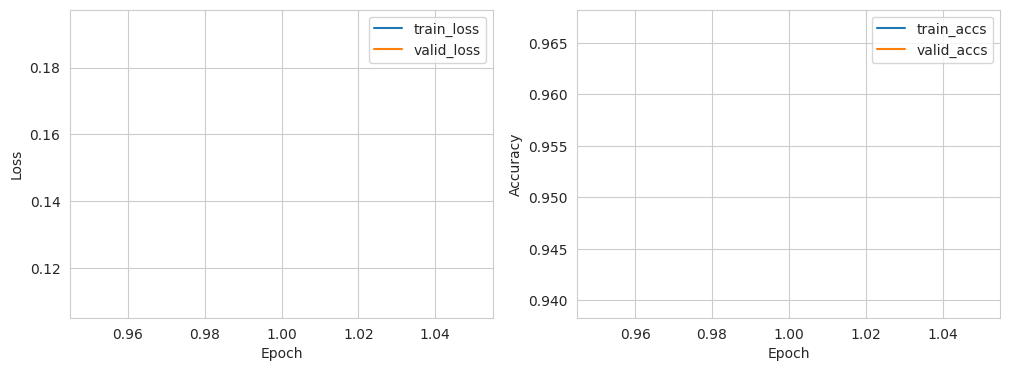

100%|██████████| 51/51 [00:18<00:00,  2.70it/s, loss=0.104]


Loss: 0.10389281809329987, Val_losses = 0.10178795456886292
 Acc: 0.9639174517463235, val_acc: 0.964095320752872


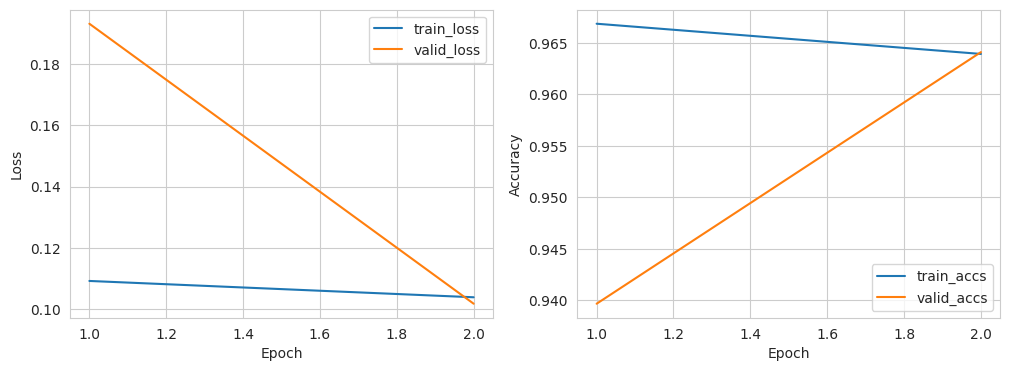

100%|██████████| 51/51 [00:19<00:00,  2.67it/s, loss=0.0711]


Loss: 0.07111561298370361, Val_losses = 0.08593344688415527
 Acc: 0.9747852998621324, val_acc: 0.9695994571972919


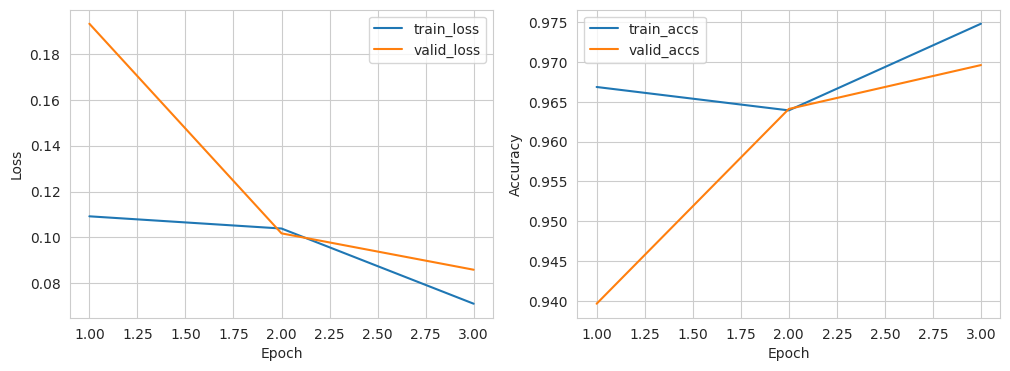

100%|██████████| 51/51 [00:19<00:00,  2.63it/s, loss=0.0664]


Loss: 0.06639888137578964, Val_losses = 0.079278364777565
 Acc: 0.9755715762867647, val_acc: 0.9719012339055324


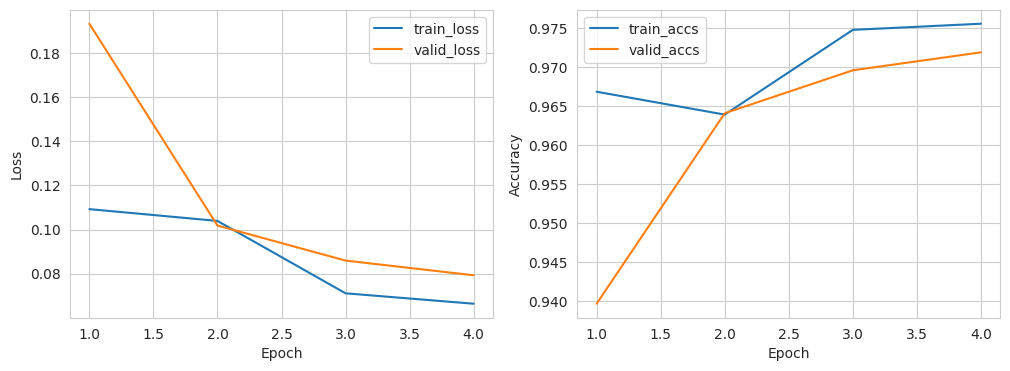

100%|██████████| 51/51 [00:19<00:00,  2.63it/s, loss=0.0619]


Loss: 0.061887066811323166, Val_losses = 0.0874359980225563
 Acc: 0.9772350834865197, val_acc: 0.9683819945140552


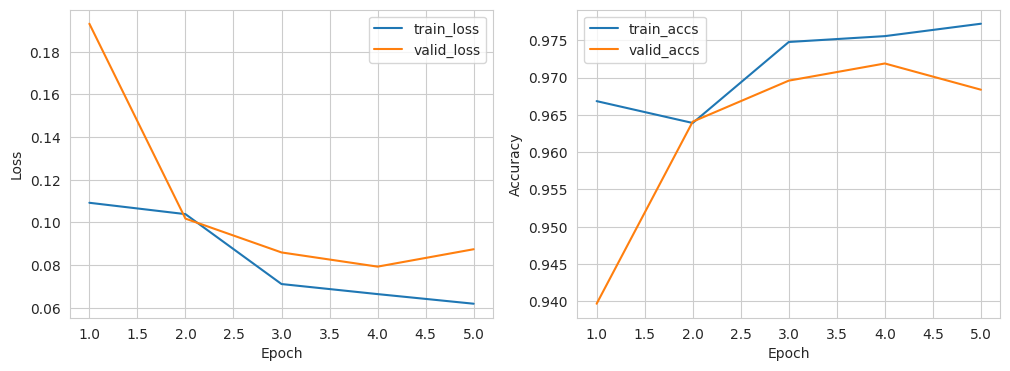

100%|██████████| 51/51 [00:19<00:00,  2.65it/s, loss=0.0672]


Loss: 0.06721941381692886, Val_losses = 0.08780131489038467
 Acc: 0.9742994121476716, val_acc: 0.9694260696356441


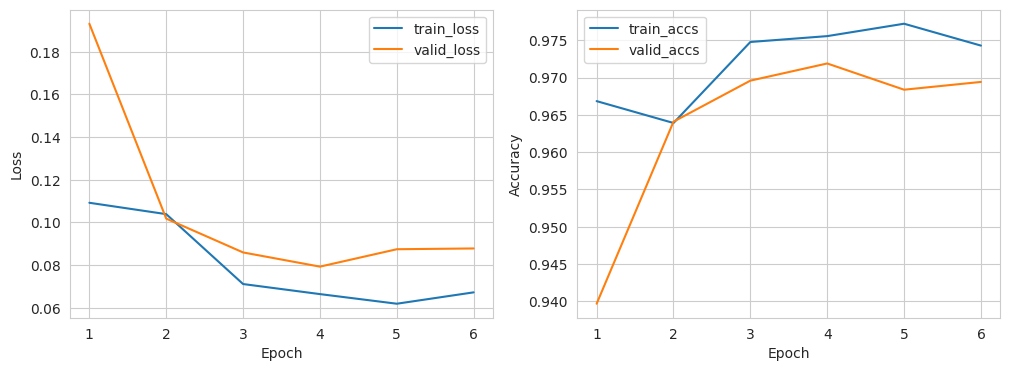

100%|██████████| 51/51 [00:19<00:00,  2.65it/s, loss=0.0653]


Loss: 0.06533005088567734, Val_losses = 0.07653015106916428
 Acc: 0.9756828756893382, val_acc: 0.9717471009941511


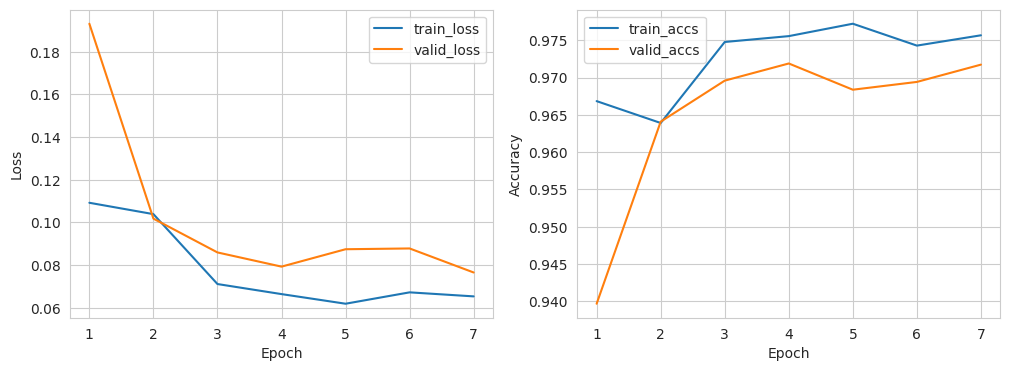

100%|██████████| 51/51 [00:19<00:00,  2.65it/s, loss=0.0654]


Loss: 0.06537898629903793, Val_losses = 0.08063363283872604
 Acc: 0.9750318340226716, val_acc: 0.9697046006452226


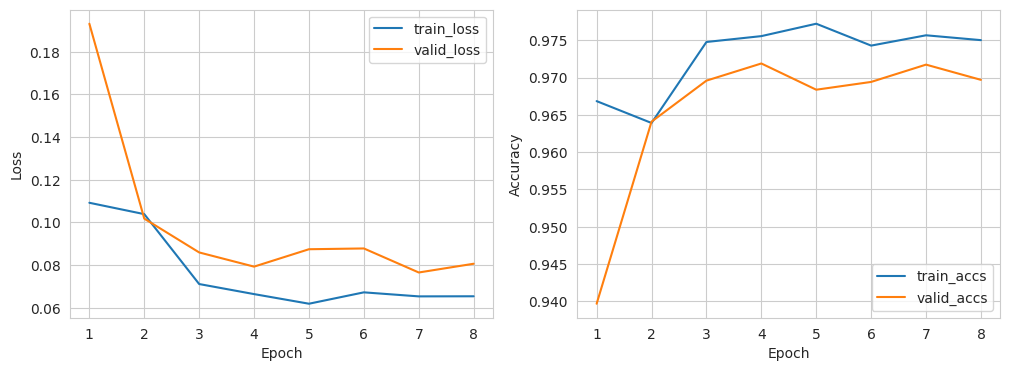

100%|██████████| 51/51 [00:19<00:00,  2.65it/s, loss=0.0586]


Loss: 0.05857313424348831, Val_losses = 0.07994150370359421
 Acc: 0.977688658471201, val_acc: 0.9696337928908699


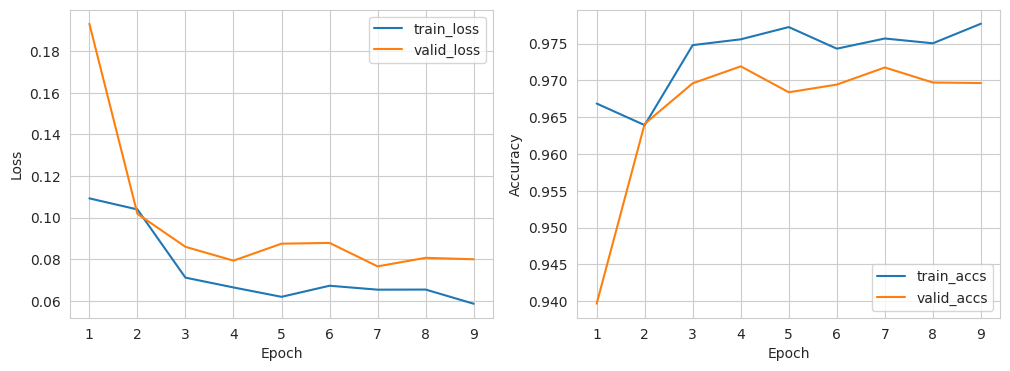

100%|██████████| 51/51 [00:19<00:00,  2.64it/s, loss=0.0575]


Loss: 0.05752809718251228, Val_losses = 0.06388162821531296
 Acc: 0.9783456839767157, val_acc: 0.9756342638350729


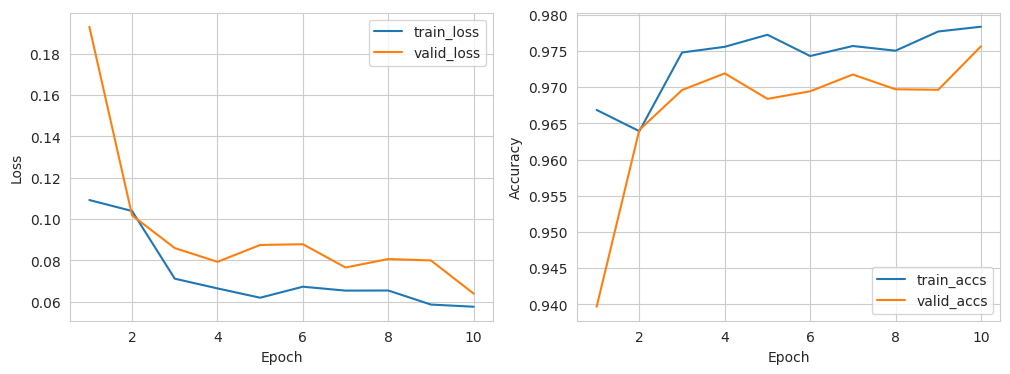

100%|██████████| 51/51 [00:19<00:00,  2.65it/s, loss=0.0556]


Loss: 0.0556066520512104, Val_losses = 0.06485915184020996
 Acc: 0.9791858149509803, val_acc: 0.9747895271547379


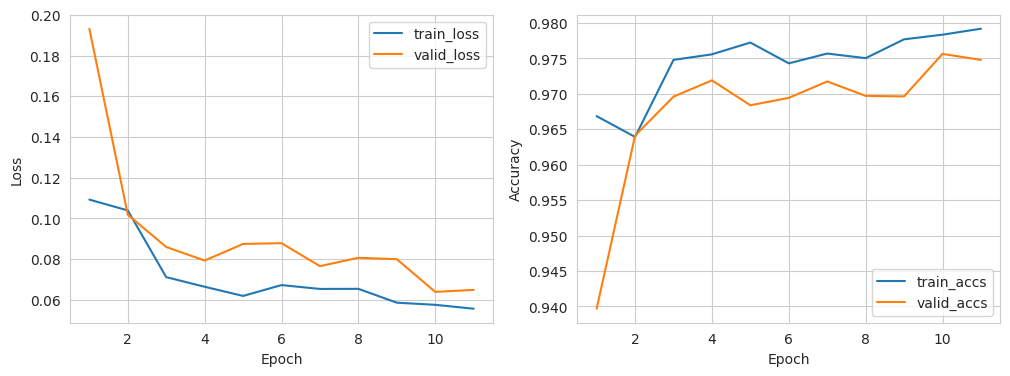

100%|██████████| 51/51 [00:19<00:00,  2.65it/s, loss=0.053]


Loss: 0.05302413925528526, Val_losses = 0.058322515338659286
 Acc: 0.9796728994332108, val_acc: 0.9770671236045045


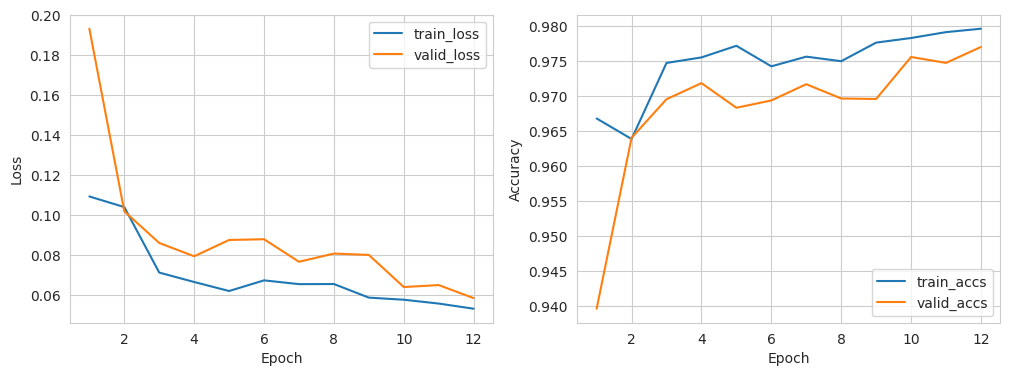

100%|██████████| 51/51 [00:19<00:00,  2.65it/s, loss=0.0514]


Loss: 0.051351387053728104, Val_losses = 0.06216355785727501
 Acc: 0.9801863128063726, val_acc: 0.9756148177663059


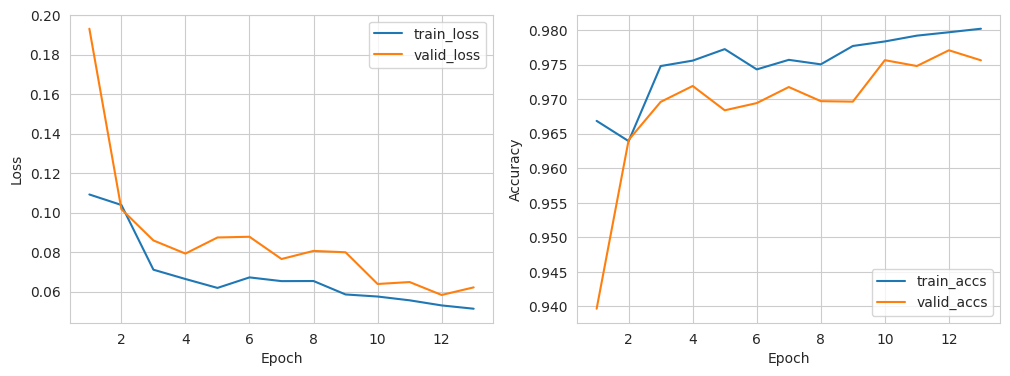

100%|██████████| 51/51 [00:19<00:00,  2.64it/s, loss=0.0491]


Loss: 0.04909166321158409, Val_losses = 0.05612307786941528
 Acc: 0.9810192631740197, val_acc: 0.9781010159454893


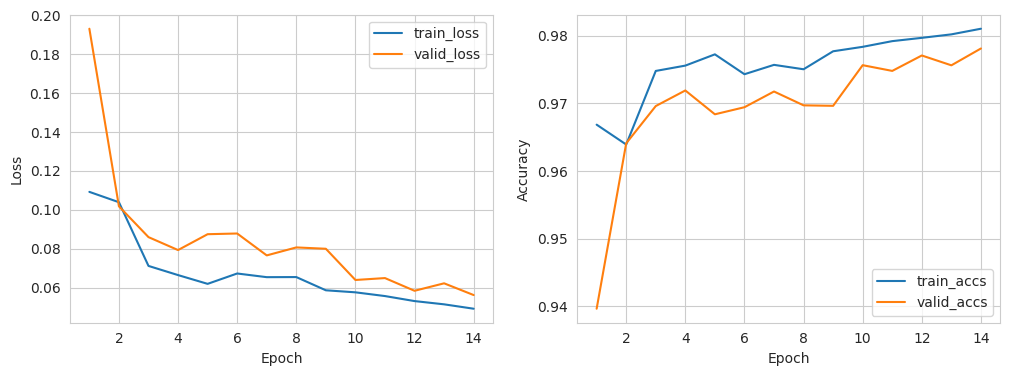

100%|██████████| 51/51 [00:19<00:00,  2.65it/s, loss=0.0464]


Loss: 0.04640265181660652, Val_losses = 0.05454552173614502
 Acc: 0.9820329254748774, val_acc: 0.9784447762273972


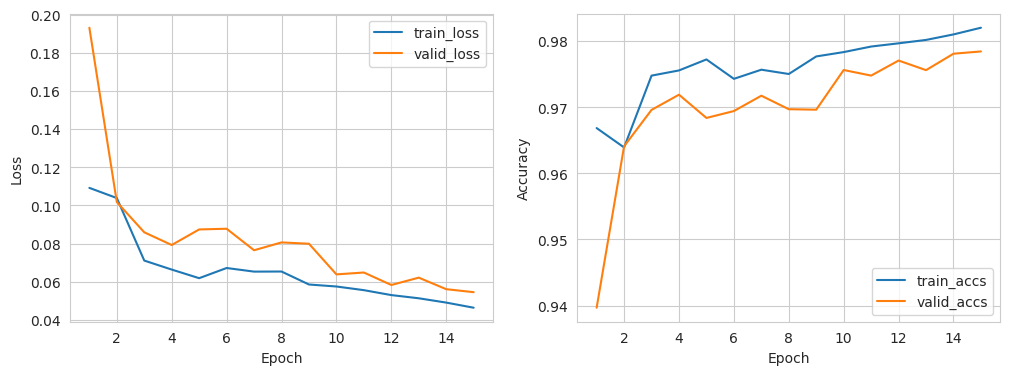

In [50]:
# Extra parameters:
num_epochs = 15

step = 0

# Initialize lists for training and validation
train_iter = []
train_loss, train_accs = [], []
valid_iter = []
valid_loss, valid_accs = [], []

# Initialize model:
model = UNET().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Scaler:
scaler = torch.cuda.amp.GradScaler()

# Train network
model.train()
for epoch in range(num_epochs):

  loss, train_acc = train_fn(train_batches, model, scaler, optimizer, loss_fn, device)
  val_loss, val_acc = validation_fn(valid_batches, model)

  # Append logging information:
  train_iter.append(epoch+1)
  train_loss.append(loss)
  train_accs.append(train_acc)
  valid_loss.append(val_loss)
  valid_accs.append(val_acc)

  # Plot log:
  print(f"Loss: {loss}, Val_losses = {val_loss}\n Acc: {train_acc}, val_acc: {val_acc}")
  logging_fn(train_iter, train_loss, valid_loss, train_accs, valid_accs, False)

Option to save the model for later use:

In [51]:
# Choose name of model file (without extension):
model_file = 'large_model_with_noise_50_pct'               # Change line for newly trained model
model_path = saved_models + model_file + '.pth'

In [52]:
# Save model, if needed:
torch.save({
    'model_state': model.state_dict(),
    'loss': loss_fn,
    'optimizer_state': optimizer.state_dict(),
}, model_path)

Initialize saved model by running the cell below (**remember to change first line**):

In [ ]:
# Choose model to load:
model_file = 'large_baseline_model'             # Change line if necessary
model_path = saved_models + model_file + '.pth'

In [29]:
# Raise exception if model file does not exist:
if not os.path.exists(model_path):
  raise Exception('Filename is incorrect - please try again.')

model = UNET().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Load model:
checkpoint = torch.load(model_path)
model.load_state_dict(checkpoint['model_state'])
optimizer.load_state_dict(checkpoint['optimizer_state'])
loss = checkpoint['loss']


##$\textbf{Evaluate model results}$

Evaluate test images using the cropped 128x128 images:

675
Mean accuracy: 0.9459126790364584


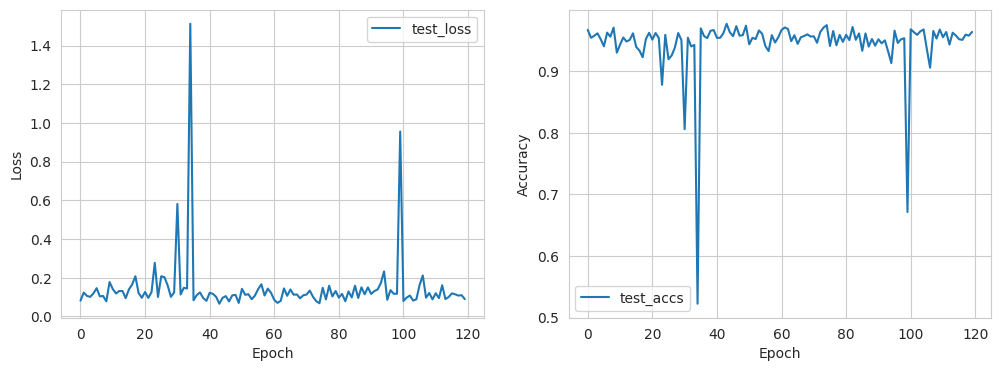

In [53]:
# Get a random sample of test data images:
sample_size = 120
print(len(test_data))
sample_sets = DataLoader(test_data, batch_size=sample_size, shuffle=True, num_workers=0, collate_fn=None, pin_memory=False)


# List of images:
input_lst = []
label_lst = []
pred_lst = []
loss = []
acc_lst = []
iteration = []

# Get first batch:
first_sample_set = next(iter(sample_sets))
model.eval()

# Create predictions and images:
for i, sample_test_data in enumerate(first_sample_set):

  # Split data:
  test_inputs, test_labels = torch.split(sample_test_data, [1,3], dim=0)
  test_inputs, test_labels = test_inputs.to(device), test_labels.to(device)

  # Make prediction:
  predictions = model(test_inputs.unsqueeze(1))

  # Find accuracy and loss:
  pred_loss = loss_fn(predictions, test_labels.unsqueeze(0))
  pred_acc = accuracy(predictions, test_labels.unsqueeze(0))

  # Append to lists:
  iteration.append(i)
  loss.append(pred_loss)
  acc_lst.append(pred_acc)
  input_lst.append(rescaled_tensor_img(test_inputs.to('cpu')))
  label_lst.append(rescaled_tensor_img(test_labels.to('cpu')))
  pred_lst.append(pred_to_img(predictions.to('cpu')))

# Plot images and show log:
# show_comparisons(input_lst, label_lst, pred_lst) # ** OUT COMMENT TO PLOT INPUT-LABEL-PREDICTION IMAGES **
print(f"Mean accuracy: {np.mean(acc_lst)}")
logging_fn(iteration, loss, [torch.tensor(0) for _ in range(len(loss))], acc_lst, [torch.tensor(0) for _ in range(len(loss))], True)


Generalizing for the fullsized 501x501 image:

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


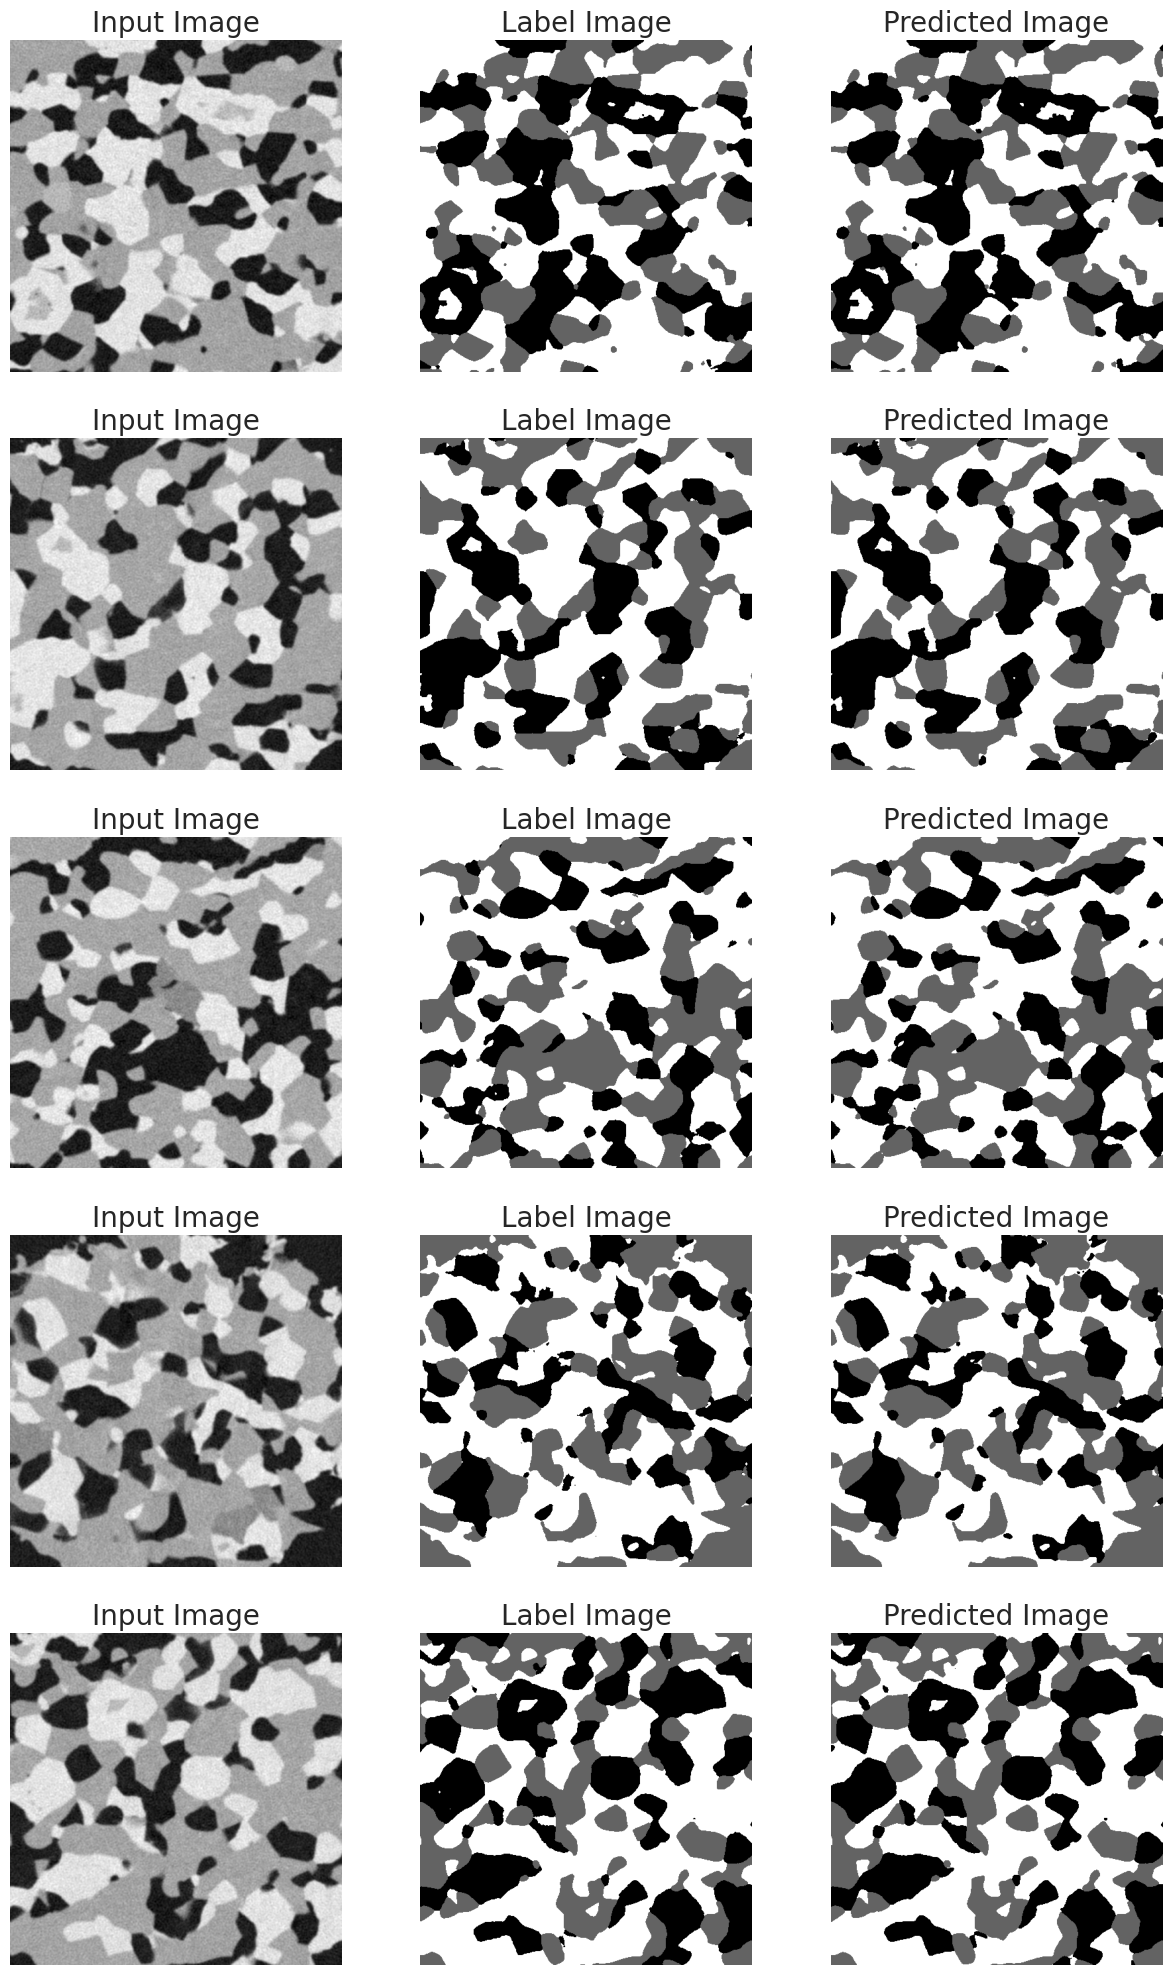

Mean accuracy: 0.986929135740495


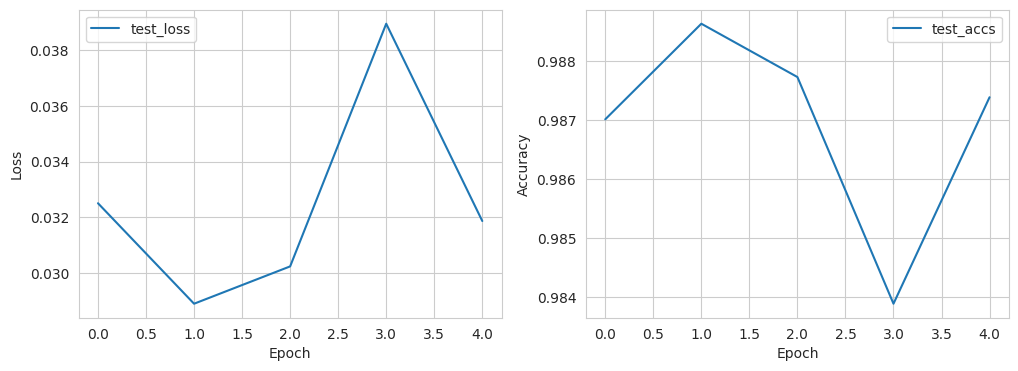

In [57]:
def transform_fullsized_input(path):
  img = Image.open(path)
  img_array = np.array(img).astype(np.float32) # img as np array
  img_tensor = torch.from_numpy(img_array).unsqueeze(0) # Format to tensor
  return normalize_tensor(img_tensor)


# Get a random sample of test data images:
sample_size = 5
random_indices = np.random.choice(len(data_paths), sample_size)



input_sample = torch.stack([transform_fullsized_input(data_paths[idx]) for idx in random_indices])
label_sample = torch.stack([apply_label_transform(Image.open(label_paths[idx])) for idx in random_indices])

# Create label masks and compress:
masks = create_masks(label_sample)
test_sample = torch.cat([input_sample, masks], dim=1)

# List of images:
input_lst = []
label_lst = []
pred_lst = []
loss = []
acc_lst = []
iteration = []

model.eval()
# Create predictions and images:
for i, sample_test_data in enumerate(test_sample):

  # Split data:
  test_inputs, test_labels = torch.split(sample_test_data, [1,3], dim=0)
  test_inputs, test_labels = test_inputs.to(device), test_labels.to(device)

  # Make prediction:
  predictions = model(test_inputs.unsqueeze(1))

  # Find accuracy and loss:
  pred_loss = loss_fn(predictions, test_labels.unsqueeze(0))
  pred_acc = accuracy(predictions, test_labels.unsqueeze(0))

  # Append to lists:
  iteration.append(i)
  loss.append(pred_loss)
  acc_lst.append(pred_acc)
  input_lst.append(rescaled_tensor_img(test_inputs.to('cpu')))
  label_lst.append(rescaled_tensor_img(test_labels.to('cpu')))
  pred_lst.append(pred_to_img(predictions.to('cpu')))

# Plot images and show log:
show_comparisons(input_lst, label_lst, pred_lst, title_fontsize=20) # ** OUT COMMENT TO PLOT INPUT-LABEL-PREDICTION IMAGES **
print(f"Mean accuracy: {np.mean(acc_lst)}")
logging_fn(iteration, loss, [torch.tensor(0) for _ in range(len(loss))], acc_lst, [torch.tensor(0) for _ in range(len(loss))], True)


##$\textbf{Plot accuracy as a function of noise level in the test images}$

Below are the results, as described in section 4.4 in the paper:

Text(0, 0.5, 'Test accuracy')

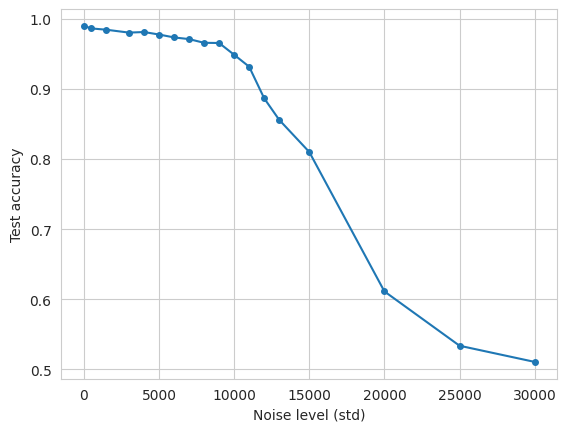

In [ ]:
# Only the test data is new (the model is only trained on the first training set)
noise_lvl = np.array([5000,500,0,1500,3000,4000,6000,7000,8000,10000,15000,20000,30000,25000,9000,11000,12000,13000])
test_accuracy = np.array([0.97762451171875,0.98631591796875,0.98988037109375,0.9844482421875,
                          0.9803466796875,0.981158447265625,0.97347412109375,0.971087646484375,
                          0.965789794921875,0.9487548828125,0.810052490234375,
                          0.61112060546875,0.51055908203125,0.53363037109375,0.96551513671875,0.93170166015625,0.886614990234375,0.855853271484375])

noise_lvl, test_accuracy = zip(*sorted(zip(noise_lvl, test_accuracy)))

plt.plot(noise_lvl,test_accuracy,'-o',markersize=4)
plt.xlabel('Noise level (std)')
plt.ylabel('Test accuracy')

